In [648]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import cianparser # https://github.com/lenarsaitov/cianparser
import distance
from jellyfish import jaro_winkler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,HalvingGridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures
from sklearn.linear_model import SGDRegressor,LinearRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,f1_score, \
    r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQxxmZm6YG54VucQ9yRgWFQXtOI-RFJ5-sOLT93LpaYGYc-vabL9LOzzkRXX-LmSROTA7hOL1C327nZ/pub?gid=213261502&single=true&output=csv')

# Первоначальная предобработка данных(квартиры на продажу в Москве и Санкт-Петербурге)

In [3]:
data.head()

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/284740225/,Sankt-Peterburg,sale,flat,1,7,1.0,38.20,419999,16044000,2023,12.0,12.0,7.812218e+10,Petrogradskij,Chkalovskoe,Petrogradskaja,Severnaja Korona
1,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/280819981/,Sankt-Peterburg,sale,flat,13,25,1.0,36.81,33201,6706674,2024,10.0,13.0,7.812218e+10,Primorskij,Kolomjagi,Prospekt Prosveschenija,Frends ZhK
2,GloraX,developer,https://spb.cian.ru/sale/flat/279507591/,Sankt-Peterburg,sale,flat,5,19,1.0,36.76,265777,9769999,2025,11.0,11.0,7.812213e+10,Vasileostrovskij,Morskoj,Zenit,Gloraks Premium Vasileostrovskij ZhK
3,Группа Эталон,developer,https://spb.cian.ru/sale/flat/285017335/,Sankt-Peterburg,sale,flat,13,18,1.0,32.60,303116,9881582,2022,21.0,-1.0,7.812213e+10,Admiraltejskij,Izmajlovskoe,Moskovskie vorota,Kvartal Galaktika
4,GloraX,developer,https://spb.cian.ru/sale/flat/279351916/,Sankt-Peterburg,sale,flat,11,14,1.0,34.44,322009,11089999,2024,12.0,13.0,7.812213e+10,Krasnogvardejskij,Malaja Ohta,Ladozhskaja,Glorax Zanevskij


In [4]:
data.shape

(15495, 20)

In [5]:
data['flat_id'] = data['link'].str.extract('(\d+)')

In [6]:
data.drop('link', axis = 1,inplace = True)

In [7]:
data.drop(['accommodation_type','deal_type'],axis = 1,inplace = True)

In [8]:
data.head()

,author,author_type,city,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex,flat_id
0,Петербургская Строительная Компания,developer,Sankt-Peterburg,1,7,1.0,38.20,419999,16044000,2023,12.0,12.0,7.812218e+10,Petrogradskij,Chkalovskoe,Petrogradskaja,Severnaja Korona,284740225
1,Петербургская Строительная Компания,developer,Sankt-Peterburg,13,25,1.0,36.81,33201,6706674,2024,10.0,13.0,7.812218e+10,Primorskij,Kolomjagi,Prospekt Prosveschenija,Frends ZhK,280819981
2,GloraX,developer,Sankt-Peterburg,5,19,1.0,36.76,265777,9769999,2025,11.0,11.0,7.812213e+10,Vasileostrovskij,Morskoj,Zenit,Gloraks Premium Vasileostrovskij ZhK,279507591
3,Группа Эталон,developer,Sankt-Peterburg,13,18,1.0,32.60,303116,9881582,2022,21.0,-1.0,7.812213e+10,Admiraltejskij,Izmajlovskoe,Moskovskie vorota,Kvartal Galaktika,285017335
4,GloraX,developer,Sankt-Peterburg,11,14,1.0,34.44,322009,11089999,2024,12.0,13.0,7.812213e+10,Krasnogvardejskij,Malaja Ohta,Ladozhskaja,Glorax Zanevskij,279351916


In [9]:
data.drop('phone', axis =1, inplace=True)

In [10]:
data_duplicated_indexes = data[data.duplicated() == True].index

In [11]:
data = data.drop(data_duplicated_indexes, axis =0)

In [12]:
data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']] = data[['total_meters', 'price_per_m2','year_of_construction','living_meters','kitchen_meters']].replace(-1.0, None)

In [14]:
data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']].dtypes

total_meters            object
price_per_m2             int64
year_of_construction    object
living_meters           object
kitchen_meters          object
dtype: object

In [15]:
data.isna().sum()

author                    91
author_type               80
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               9
price_per_m2               0
price                      0
year_of_construction     719
living_meters           3278
kitchen_meters          3508
district                 764
street                  1527
underground              643
residential_complex     5898
flat_id                    0
dtype: int64

In [20]:
data.drop(data[(data.isna().sum(axis=1) >= 4)].index, axis = 0, inplace =True)

In [21]:
data.loc[(data.price_per_m2 <=0),'price_per_m2'] = None 

In [22]:
data.isna().sum()

author                    29
author_type               18
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               2
price_per_m2               2
price                      0
year_of_construction     436
living_meters           2863
kitchen_meters          3033
district                 558
street                  1301
underground              551
residential_complex     5429
flat_id                    0
dtype: int64

In [23]:
data['author'].fillna(data['author'].mode()[0], inplace =True)
data['author_type'].fillna(data['author_type'].mode()[0], inplace =True)

In [24]:
data[['total_meters',
             'living_meters',
             'kitchen_meters']] = data[['total_meters','living_meters','kitchen_meters']].astype('float64')

In [25]:
data['total_meters'].fillna(data['total_meters'].median(), inplace =True)
data['price_per_m2'].fillna(data['price_per_m2'].median(), inplace =True)

In [ ]:
data['year_of_construction'] = data['year_of_construction'].astype('int64',errors='ignore')

In [26]:
data.isna().sum()

author                     0
author_type                0
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction     436
living_meters           2863
kitchen_meters          3033
district                 558
street                  1301
underground              551
residential_complex     5429
flat_id                    0
dtype: int64

In [39]:
data = data.drop(data[data['year_of_construction'].isna()].index, axis = 0)

In [54]:
data = data.drop(data[data['living_meters'] < 0].index, axis = 0)

# EDA

In [55]:
data.isna().sum()

author                     0
author_type                0
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction       0
living_meters           2765
kitchen_meters          2954
district                 558
street                  1296
underground              533
residential_complex     5177
flat_id                    0
dtype: int64

In [528]:
data.describe(include=['int64','float64'])

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,living_meters,kitchen_meters
count,14504.000000,14504.000000,14504.000000,14504.000000,1.450400e+04,1.450400e+04,11739.000000,11550.000000
mean,8.317774,16.197670,2.472697,88.136788,4.512910e+05,4.611653e+07,44.074137,14.492996
std,8.660514,12.163349,1.560667,69.353261,1.906043e+06,8.654453e+07,39.006236,10.208662
min,1.000000,1.000000,0.500000,0.100000,1.785700e+04,1.750000e+06,0.000000,0.000000
25%,3.000000,8.000000,1.000000,36.600000,2.000000e+05,8.826646e+06,16.000000,7.600000
50%,5.000000,13.000000,2.000000,66.175000,2.877165e+05,1.680000e+07,31.000000,12.000000
75%,11.000000,22.000000,4.000000,120.000000,4.537982e+05,4.452054e+07,60.000000,19.000000
max,92.000000,109.000000,5.000000,659.400000,1.500000e+08,2.033930e+09,450.000000,116.000000


In [529]:
data.describe(include=['O'])

,author,author_type,city,year_of_construction,district,street,underground,residential_complex,flat_id
count,14504,14504,14504,14504,13946,13208,13971,9327,14504
unique,2082,7,2,207,146,1770,337,1233,14497
top,ПИК,real_estate_agent,Moskva,2023,Primorskij,Petrovskij,Komendantskij prospekt,Tsvetnoj Gorod,279024365
freq,627,8131,7564,2080,1140,287,416,138,2


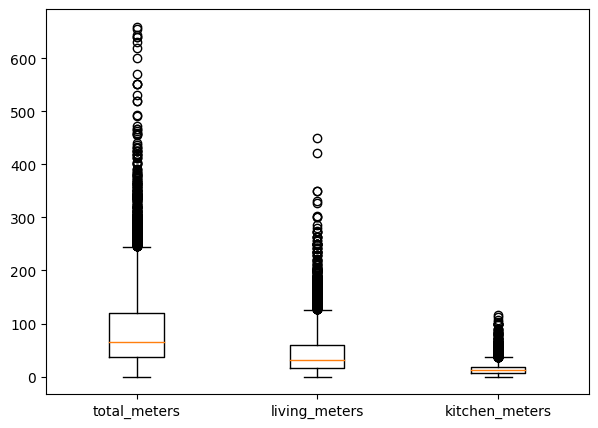

In [625]:
plt.figure(figsize=(7,5))
plt.boxplot([data['total_meters'],
             data[data['living_meters'].notnull()]['living_meters'],
             data[data['kitchen_meters'].notnull()]['kitchen_meters']])
plt.xticks([1,2,3],['total_meters','living_meters','kitchen_meters']);

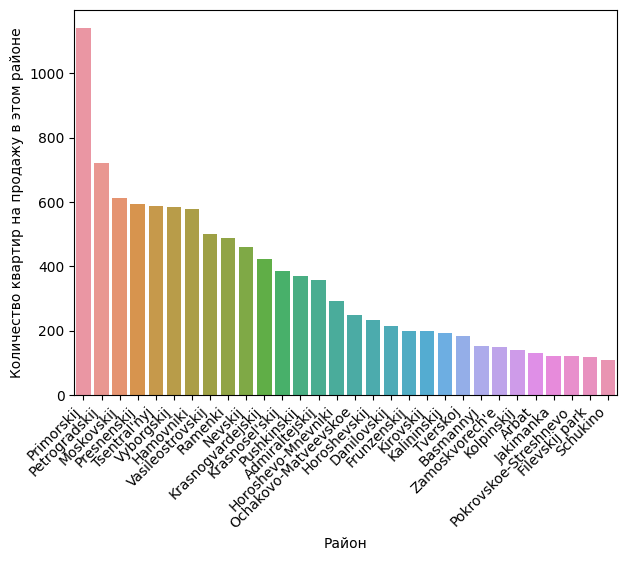

In [638]:
district_top30 = data.district.value_counts()
plt.figure(figsize=(7,5))
sns.barplot(x = district_top30.index[:30], y =district_top30[:30])
plt.ylabel('Количество квартир на продажу в этом районе')
plt.xlabel('Район')
plt.xticks(rotation = 45,ha='right');

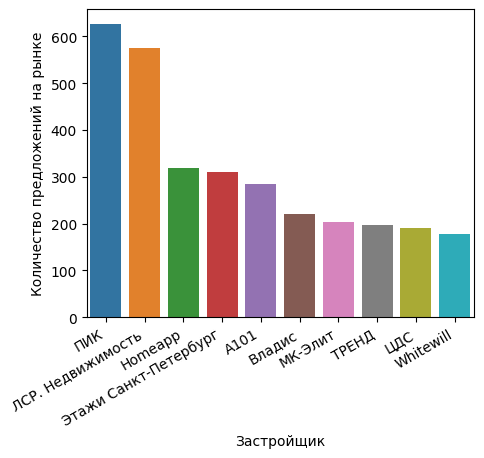

In [532]:
developers_top10 = data['author'].value_counts()[:10]
plt.figure(figsize=(5,4))
sns.barplot(x = developers_top10.index, y =developers_top10)
plt.ylabel('Количество предложений на рынке')
plt.xlabel('Застройщик')
plt.xticks(rotation = 30,ha='right');

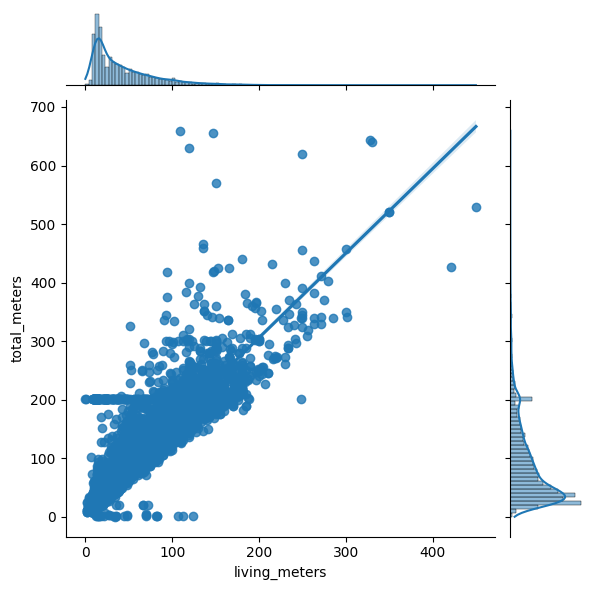

In [643]:
sns.jointplot(x = data.living_meters,y = data['total_meters'], kind = 'reg');

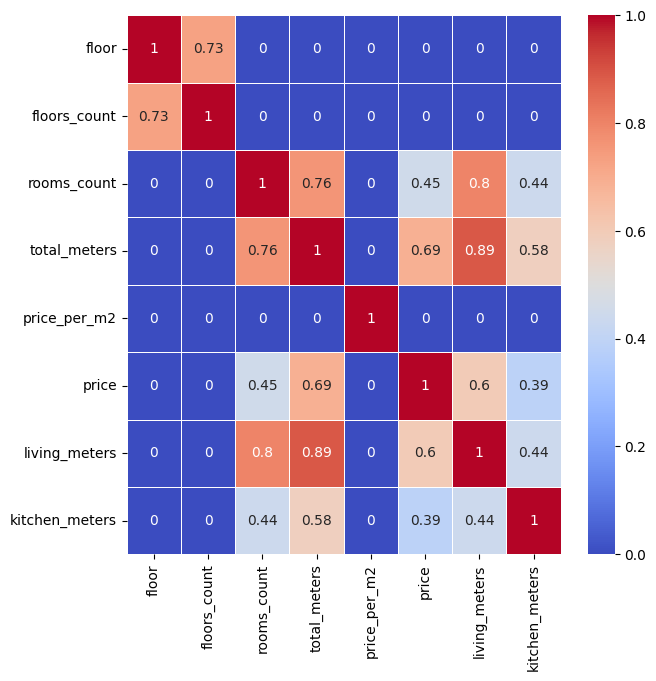

In [647]:
corr_matrix = data.corr(numeric_only =True)
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.35] = 0
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix,annot=True,linewidths = 0.5, cmap = 'coolwarm');

## living_meters (исследование признака и заполнение пропусков)

<Figure size 700x700 with 0 Axes>

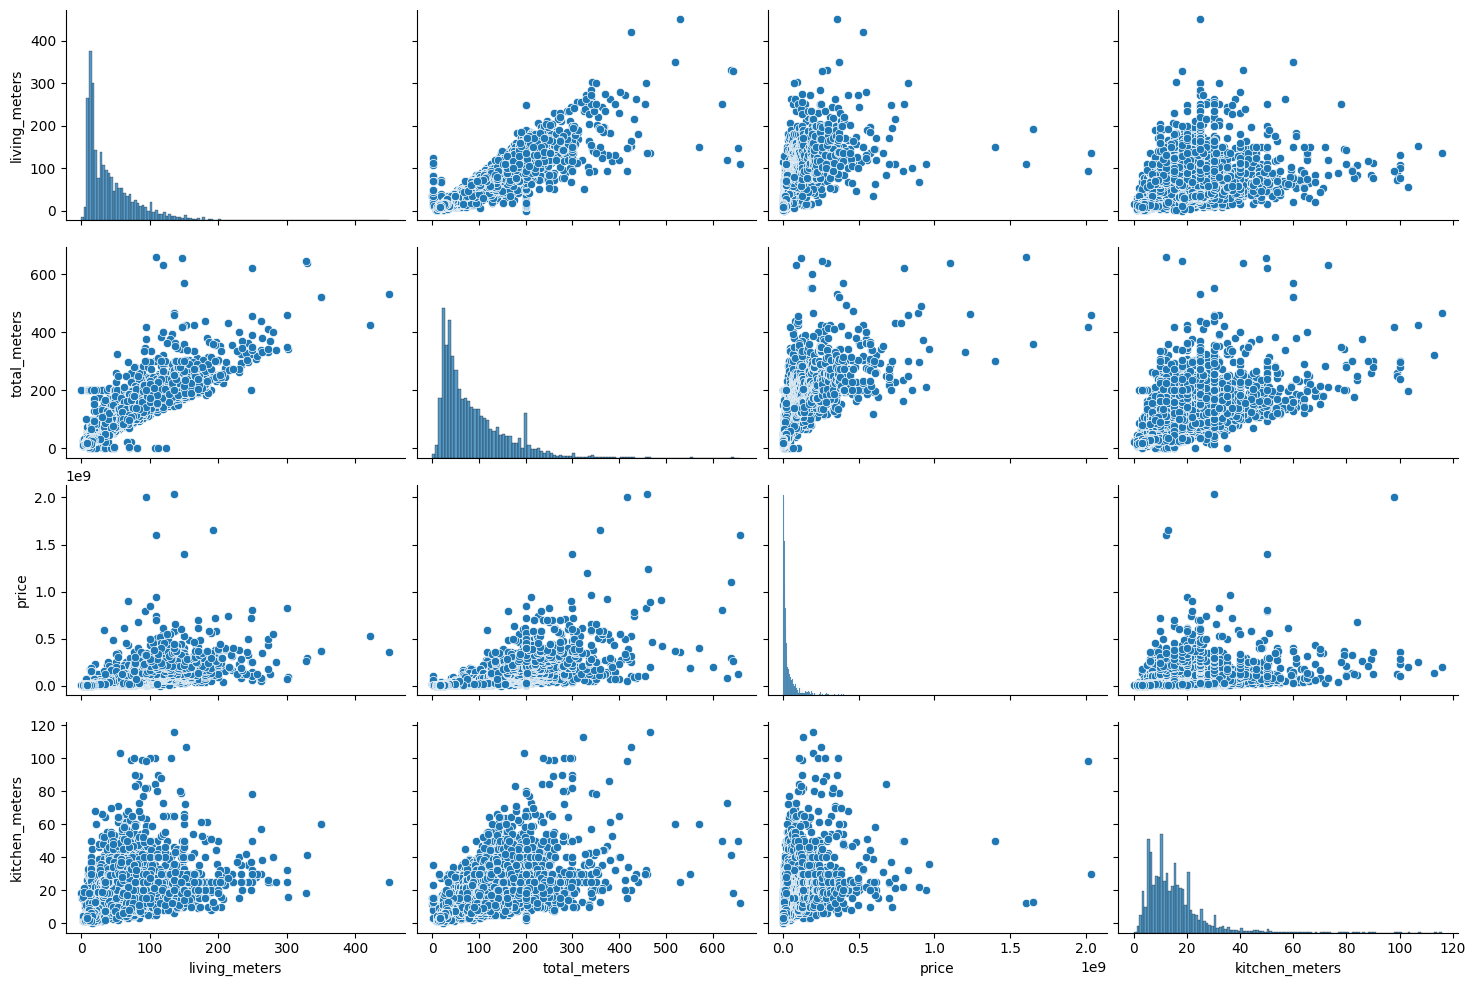

In [69]:
plt.figure(figsize = (7,7))
sns.pairplot(data[['living_meters','total_meters','price','kitchen_meters']],
             height=2.5, aspect=1.5, 
             diag_kind='hist');

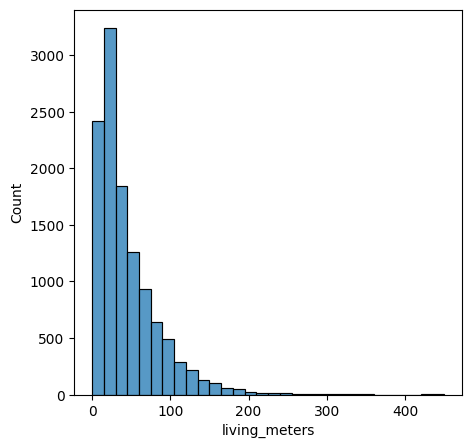

In [64]:
plt.figure(figsize = (5,5))
sns.histplot(data=data['living_meters'],bins =30);

In [606]:
# создаю датасет для регрессии
data_reg = data[['living_meters','total_meters','price','kitchen_meters','rooms_count']].copy()

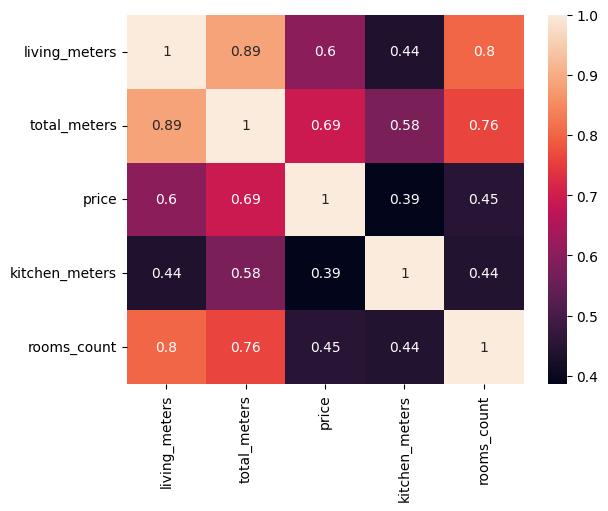

In [571]:
corr_matrix = data_reg.corr()
sns.heatmap(corr_matrix, annot =True);

In [585]:
# проверяю линейную связь между целевой и независимыми переменными
living_meters_nonan = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())]['living_meters']

pvalue1 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'total_meters'].values)[1]

pvalue2 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values)[1]

pvalue3 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'price'].values)[1]

pvalue4 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'rooms_count'].values)[1]
print(pvalue1,pvalue2,pvalue3)

0.0 0.0 0.0


In [583]:
# проверка мультиколлинеарности
pear1 = pearsonr(data_reg.loc[living_meters_nonan.index,'total_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values)

pear2 = pearsonr(data_reg.loc[living_meters_nonan.index,'total_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'price'].values)

pear3 = pearsonr(data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'price'].values)
pear4 = pearsonr(data_reg.loc[living_meters_nonan.index,'rooms_count'].values,
                   data_reg.loc[living_meters_nonan.index,'total_meters'].values)
print(pear1,pear2,pear3,pear4)

PearsonRResult(statistic=0.5940482893007168, pvalue=0.0) PearsonRResult(statistic=0.6370365508726645, pvalue=0.0) PearsonRResult(statistic=0.3951151988041336, pvalue=0.0) PearsonRResult(statistic=0.7559550380435389, pvalue=0.0)


## Условия для линейной регрессии
1. Количественные переменные
2. линейная связь между зависимой и независимыми переменными(есть)
3. нормальное распределение ошибок
4. Гомоскедастичность(остатки имеют плюс-минус равную дисперсию во всех значениях х)
5. Отсутствует мультиколлинеарность(независимые переменные:,'total_meters','kitchen_meters','price'), почти отсутсвует

## LinearRegression

In [759]:
lr = LinearRegression(fit_intercept=True)
y_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())].iloc[:,[1,2,3,4]]
lr.fit(X_living_meters,y_living_meters)
y_pred = lr.predict(X_living_meters)
resid = y_living_meters - y_pred

In [575]:
lr.intercept_

-3.5570428119822424

In [760]:
# тест на автокорреляцию остатков
sm.stats.stattools.durbin_watson(resid)

1.749007130264861

Автокорреляция остатков почти отсутствует, так как тест показал 1.69(2 это полное отсутствие)

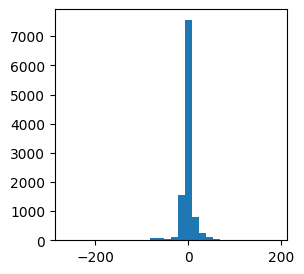

In [761]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

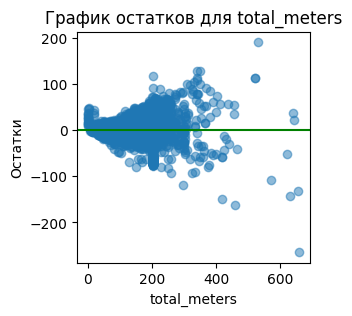

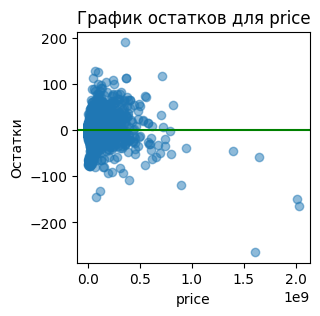

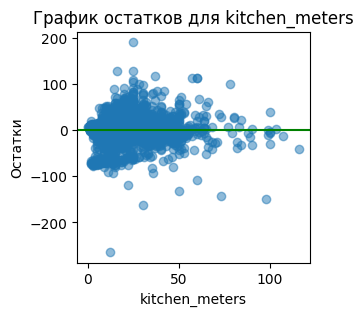

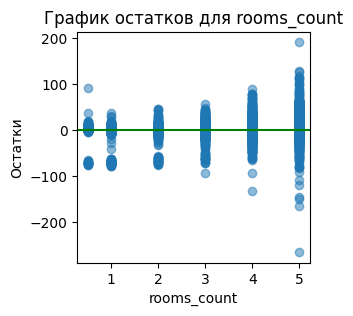

In [762]:
# гомоскедастичность остатков
for i in range(0,4):
    plt.figure(figsize= (3,3))
    plt.scatter(X_living_meters.iloc[:,i].values, resid.values, alpha=0.5)
    plt.axhline(y=0, color='g', linestyle='-')
    plt.xlabel(f'{X_living_meters.columns[i]}')
    plt.ylabel('Остатки')
    plt.title(f'График остатков для {X_living_meters.columns[i]}')
plt.show()

In [763]:
mae = mean_absolute_error(y_living_meters.values, y_pred) 
# mae насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_living_meters.values, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_living_meters.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

mae: 7.901 
mse: 226.323 
rmse: 15.044 
r2:0.848


In [581]:
lr.score(X_living_meters, y_living_meters)

0.848379592718314

In [582]:
SSR = np.sum(resid**2)
# Стандартная ошибка оценки (Standard Error of the Estimate, SEE)
SSE = np.sqrt(SSR / (len(y_living_meters) - X_living_meters.shape[1]+1))
# SSR - сумма квадратов остатков, n - количество наблюдений и p - количество параметров (коэффициентов), включая константу.
print(f'SSE:{SSE}')

SSE:15.046148778326339


In [602]:
scores = cross_val_score(lr, X_living_meters, y_living_meters, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV R^2: 0.769 +- 0.094


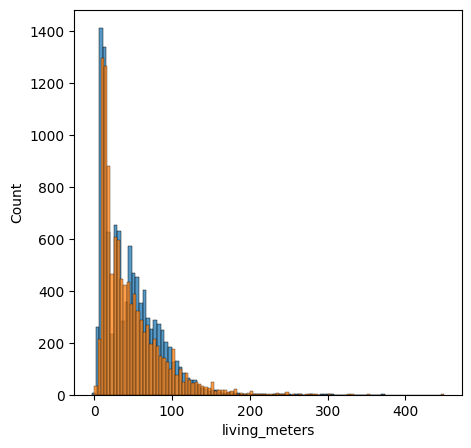

In [605]:
plt.figure(figsize=(5, 5))
sns.histplot(y_pred)
sns.histplot(y_living_meters);

## Полиномиальная регрессия(лучший набор признаков : 1,3,4)

In [777]:
y_living_meters = data_reg[(data_reg['living_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull())].iloc[:,[1,2,4]]

poly = PolynomialFeatures(degree=2)
X_living_meters = poly.fit_transform(X_living_meters)
lr = LinearRegression(fit_intercept=True)

lr.fit(X_living_meters,y_living_meters)
y_pred = lr.predict(X_living_meters)
resid = y_living_meters - y_pred

In [780]:
sm.stats.stattools.durbin_watson(resid)

1.8118203050521522

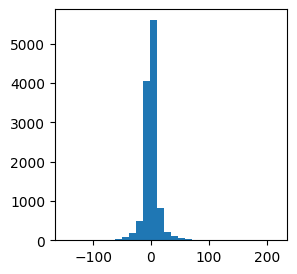

In [779]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

In [774]:
mae = mean_absolute_error(y_living_meters.values, y_pred) 
# mae насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_living_meters.values, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_living_meters.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

mae: 8.283 
mse: 197.293 
rmse: 14.046 
r2:0.870


In [775]:
scores = cross_val_score(lr, X_living_meters, y_living_meters, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV R^2: 0.746 +- 0.102


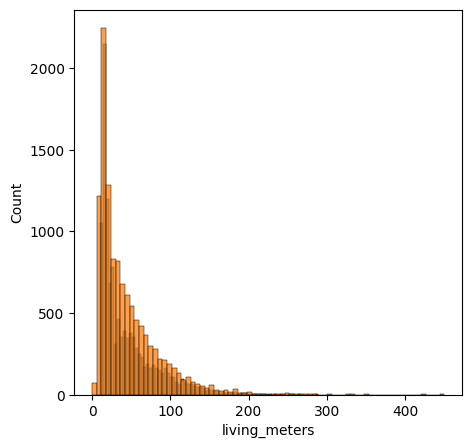

In [754]:
plt.figure(figsize=(5, 5))
sns.histplot(y_pred,bins = 75)
sns.histplot(y_living_meters,bins = 75);

In [786]:
living_meters_nan = data[data.living_meters.isna()][['total_meters','price','rooms_count']]
living_meters_nan = poly.fit_transform(living_meters_nan)
living_meters_nan = lr.predict(living_meters_nan)

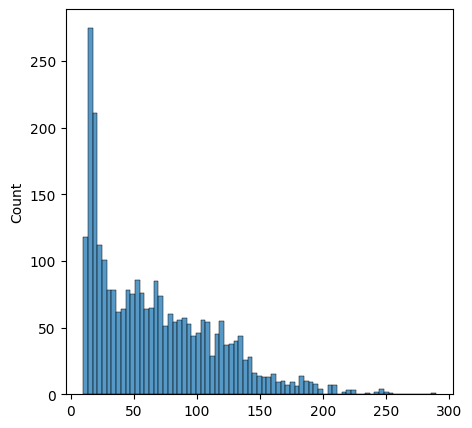

In [788]:
plt.figure(figsize=(5, 5))
sns.histplot(living_meters_nan,bins = 75);

## Удаление выбросов в price и price_per_m2

In [ ]:
iqr = stats.iqr(data.price) # разница между 3 и 1 квартилями
q1 = np.quantile(data.price, 0.25)
q3 = np.quantile(data.price, 0.75)
lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.5
outliers = data.price[(data.price < lower) | (data.price > upper)]
data.drop(outliers.index, inplace = True)

In [ ]:
iqr = stats.iqr(data.price_per_m2) # разница между квантилем 3 и 1 квартилями
q1 = np.percentile(data.price_per_m2, 25)
q3 = np.percentile(data.price_per_m2, 75)
lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.5
outliers = data.price_per_m2[(data.price_per_m2 < lower) | (data.price_per_m2 > upper)]
data.drop(outliers.index, inplace = True)

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 1)
sns.boxplot(data.price,ax = axes[0])
axes[0].set_title('price')
sns.boxplot(data.price_per_m2, ax = axes[1])
axes[1].set_title('price_per_m2');

In [ ]:
data[data.price > (q3 + iqr * 1.5)]

## Заполнение пропусков методом случайного леса
## residential_complex

In [ ]:
X = data.loc[~data.residential_complex.isna(), ['author','author_type','city','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters']]

y = data.loc[~data.residential_complex.isna(),'residential_complex']
# это нужно предсказать
x_nan_residential_complex = data.loc[data.residential_complex.isna(), ['author','author_type','city','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_test,y_test нужны для проверки качества

In [ ]:
classes_less_than_5 = y_train.value_counts()[y_train.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
x_train_resampled, y_train_resampled  = ROS.fit_resample(X_train,y_train)

In [ ]:
label_encoder = LabelEncoder()
for item in ['author','author_type','city','year_of_construction']:
    X_test[item] = label_encoder.fit_transform(X_test[item])
    x_nan_residential_complex[item] = label_encoder.fit_transform(x_nan_residential_complex[item])
    x_train_resampled[item] = label_encoder.fit_transform(x_train_resampled[item])

## Подбор оптимального min_resources

In [ ]:
i = 1
n_residential_complex = x_train_resampled.shape[0]
print(n_residential_complex)
while i < 3:
    n_residential_complex //=3
    print(n_residential_complex)
    i+=1
print(f'нужно использовать {n_residential_complex} с factor = 3')

## Продолжение заполнения пропусков residential_complex

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)

params = {'criterion':['entropy','gini'],
          'n_estimators':np.logspace(1.5, 2.7, num=5, endpoint=True, base=5, dtype=int).tolist(), 
          'max_depth':range(5,15),
          'min_samples_split':np.logspace(1, 2, num=5, endpoint=True, base=5, dtype=int).tolist(),
          'min_samples_leaf':np.logspace(1, 2, num=4, endpoint=True, base=5, dtype=int).tolist(),
          'max_features': ['sqrt','log2']}

halving_search = HalvingGridSearchCV(estimator=clf_rf,
                           param_grid=params,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=42),
                           aggressive_elimination=True,
                           min_resources= n_residential_complex,
                           factor= 3,          
                           n_jobs = -1)
halving_search.fit(x_train_resampled,y_train_resampled)

In [ ]:
print(halving_search.best_params_)
print(halving_search.best_score_)
importances = pd.Series((halving_search.best_estimator_.feature_importances_),index = x_train_resampled.columns)
importances

In [ ]:
residential_complex_pred = halving_search.predict(x_test_residential_complex)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, halving_search.predict(X_test),zero_division = 1)
print(precision.mean())
print(recall.mean())
print(f1_score(y_test, halving_search.predict(X_test), average='macro'))

In [ ]:
data.loc[data.residential_complex.isna(),'residential_complex'] = residential_complex_pred

## Заготовка для построения модели по уже найденным оптимальным параметрам residential_complex

In [ ]:
# clf_rf = RandomForestClassifier(criterion='entropy',
#                                 max_depth= 10,
#                                 max_features='sqrt',
#                                 min_samples_leaf=2,
#                                 min_samples_split=5,
#                                 n_estimators=50,
#                                 random_state=42)
# clf_rf.fit(x_train_resampled,y_train_resampled)
# residential_complex_nonan = clf_rf.predict(x_test)

In [ ]:
# residential_complex_nonan.shape

In [ ]:
# residential_complex_nonan = pd.Series(residential_complex_pred, 
#                                       index = data.loc[data.residential_complex.isna(),'residential_complex'].index)
# residential_complex_nonan.head()

In [ ]:
# data.loc[data.residential_complex.isna(),'residential_complex'] = residential_complex_nonan

## Заполнение пропусков в street

In [ ]:
data.isna().sum()

In [ ]:
X = data.loc[~data.street.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters', 'residential_complex']]

y = data.loc[~data.street.isna(),'street']

x_nan_street = data.loc[data.street.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters', 'residential_complex']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
classes_less_than_5 = y_train.value_counts()[y_train.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
X_train_resampled, y_train_resampled  = ROS.fit_resample(X_train,y_train)

In [ ]:
label_encoder = LabelEncoder()
for item in ['author','author_type','year_of_construction','residential_complex']:
    x_nan_street[item] = label_encoder.fit_transform(x_nan_street[item])
    X_test[item] = label_encoder.fit_transform(X_test[item])
    X_train_resampled[item] = label_encoder.fit_transform(X_train_resampled[item])

### Подбор оптимального min_resources

In [ ]:
i = 1
n_street = X_train_resampled.shape[0]
print(n_street)
while i < 3:
    n_street //=3
    print(n_street)
    i+=1
print(f'нужно использовать {n_street} с factor = 3')

## Продолжение заполнения пропусков в street

In [ ]:
# clf_rf_street = RandomForestClassifier(random_state=42)

# params_street = {'criterion':['entropy','gini'],
#           'n_estimators':np.logspace(1.5, 2.7, num=5, endpoint=True, base=5, dtype=int).tolist(), 
#           'max_depth':range(5,15),
#           'min_samples_split':np.logspace(1, 2, num=5, endpoint=True, base=5, dtype=int).tolist(),
#           'min_samples_leaf':np.logspace(1, 2, num=4, endpoint=True, base=5, dtype=int).tolist(),
#           'max_features': ['sqrt','log2']}

# halving_search_street = HalvingGridSearchCV(estimator = clf_rf_street,
#                            param_grid = params_street,
#                            aggressive_elimination=True,
#                            cv = 5, #StratifiedKFold(n_splits = 5, shuffle = True),
#                            min_resources= n_street,
#                            factor= 3,
#                            n_jobs = -1)

# halving_search_street.fit(X_train_resampled,y_train_resampled)

In [ ]:
# print(halving_search_street.best_params_)
# print(halving_search_street.best_score_)

In [ ]:
# y_test_pred = halving_search_street.predict(X_test)
# precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred,zero_division = 1)
# print(precision.mean())
# print(recall.mean())
# print(fscore.mean())
# #print(support)

## Заготовка для построения модели по уже найденным оптимальным параметрам(street)

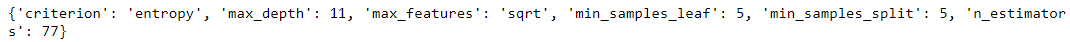

In [ ]:
clf_rf = RandomForestClassifier(criterion='entropy',
                                max_depth= 21,
                                max_features='sqrt',
                                min_samples_leaf=5,
                                min_samples_split=5,
                                n_estimators=207,
                                random_state=42)

clf_rf.fit(X_train_resampled,y_train_resampled)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, clf_rf.predict(X_test),zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())
#print(support)

street_nonan = clf_rf.predict(x_nan_street)

## Заполнение пропусков в district(не готово еще)

In [ ]:
#data.isna().sum()

In [ ]:
# X = data.loc[~data.district.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
#        'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters', 'residential_complex','street']]

# y = data.loc[~data.district.isna(),'district']

# x_nan_district = data.loc[data.district.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
#        'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters', 'residential_complex','street']]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)